# Libs

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import random
from scipy.linalg import sqrtm
import pandas as pd



# Model

In [2]:
from torchvision.models import Inception_V3_Weights

# Define a transformation to preprocess the images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception-v3
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


class InceptionV3Pool3(nn.Module):
    def __init__(self):
        super(InceptionV3Pool3, self).__init__()
        
        # Load the InceptionV3 model with the correct weights
        weights = Inception_V3_Weights.IMAGENET1K_V1
        inception = models.inception_v3(weights=weights)
        
        # Extract the required layers
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
        )
        
        # Add adaptive average pooling layer
        self.pool3 = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        return x

# Functions

In [3]:
# Function to produce embeddings for a set of images in a directory
# note: must sort filename list
def produce_embeddings(directory, model, transform):
    embeddings = []
    filenames = sorted([f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))])
    # print(filenames)

    for filename in filenames:
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('RGB')
        img = transform(img)  # Apply transformation as defined

        # Add batch dimension (batch_size=1) as PyTorch models expect batched inputs
        img = img.unsqueeze(0)

        # Set the model to evaluation mode and perform inference
        model.eval()
        with torch.no_grad():
            embedding = model(img)

        # Append the embedding to the list
        embeddings.append(embedding)

    # Stack all embeddings into a single tensor
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [4]:
# Function to calculate FID
def calculate_fid(embeddings1, embeddings2, eps=1e-5):

    # Calculate the mean and covariance of the embeddings
    mu1, sigma1 = embeddings1.mean(axis=0), np.cov(embeddings1, rowvar=False)
    mu2, sigma2 = embeddings2.mean(axis=0), np.cov(embeddings2, rowvar=False)

    # Add a small value to the diagonal to regularize the covariance matrices
    # UH: crucial for small samples where covariance matrix can be poorly conditioned
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate the sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Product of covariance matrices
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct numerical issues
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    # Ensure FID is non-negative. Probably should run a check here.
    return max(fid, 0.0)

# data and embeddings. Set category here

Creating the embeddings takes some time.
We load the embeddings of a dataset if they exist, otherwise we create and save them
This section can be greatly improved.

In [5]:
category='airplane'

# Function to save embeddings
def save_embeddings(embeddings, filename):
    filepath = f'/home/hasson/data/pro_gan_embeddings/{filename}.npy'
    np.save(filepath, embeddings)

# Function to check if a file exists
def file_exists(filename):
    filepath = f'/home/hasson/data/pro_gan_embeddings/{filename}.npy'
    return os.path.exists(filepath)

# Function to load embeddings from file
def load_embeddings(filename):
    filepath = f'/home/hasson/data/pro_gan_embeddings/{filename}.npy'
    return np.load(filepath)

# Instantiate the InceptionV3 model
embedding_model = InceptionV3Pool3()


# Path to the CSV file. NOTE: this CSV file indicates the features that should be retained
# based on the previous script. 
# for airplane we load the transportation('automobiles') csv
# Need to optimize this code. Note that the category loaded here has to match the category variable
# in the first line in this cell.
hsjcsv_path = '/home/hasson/progproj/2024Giulia/pruned_subsets/automobiles_bestsubset.csv'

# Define the directory containing images
directory_real = f'/home/hasson/data/pro_gan/{category}/0_real'
directory_fake = f'/home/hasson/data/pro_gan/{category}/1_fake'
# Construct filename
filename_real = f'embeddings_real{category}'
filename_fake = f'embeddings_fake{category}'

# Check and produce/load embeddings
if file_exists(filename_real):
    print("found real embeddings")
    embeddings_realplane = load_embeddings('embeddings_realplane')
else:
    print("did not find real embedding, producing embeddings")
    embeddings_realplane = produce_embeddings(dir_real_plane, embedding_model, transform)
    save_embeddings(embeddings_realplane, filename_real)
    embeddings_realplane = embeddings_realplane.numpy()


if file_exists(filename_fake):
    print("found fake embeddings")
    embeddings_fakeplane = load_embeddings('embeddings_fakeplane')
else:
    print("did not find fake embedding file, producing embeddings")
    embeddings_fakeplane = produce_embeddings(dir_fake_plane, embedding_model, transform)
    save_embeddings(embeddings_fakeplane, filename_fake)
    embeddings_fakeplane = embeddings_fakeplane.numpy()

print("Embedding and loading completed successfully!")


# Print the shape of the embeddings (batch_size, embedding_dimension)
print("Shape of embeddings:", embeddings_realplane.shape)
print("Shape of embeddings:", embeddings_fakeplane.shape)

found embeddings real planes
found embeddings fake planes
Embedding generation and loading completed successfully!
Shape of embeddings: (1000, 2048)
Shape of embeddings: (1000, 2048)


In [6]:
# Sanity check. Calculate FID between (realimages1, realimages2) and (realimages1, fakeimages)
fid_realplane_fakeplane = calculate_fid(embeddings_realplane, embeddings_fakeplane)
print(f"fid_realplane_fakeplane: {fid_realplane_fakeplane}")



fid_realplane_fakeplane: 38.54962972450028


## Test: apply selected features for pruning and compute FID from those

In [7]:
# Read the CSV file to get the indices
indices_df = pd.read_csv(hsjcsv_path)
indices = indices_df.iloc[:, 0].astype(int).tolist()

# Filter the embeddings to retain only the specified columns
pruned_realplane = embeddings_realplane[:, indices]
pruned_fakeplane = embeddings_fakeplane[:, indices]

# Calculate FID between pruned image sets
fid_realplaneP_fakeplaneP = calculate_fid(pruned_realplane, pruned_fakeplane)

print(f"fid_realplaneP_fakeplaneP: {fid_realplaneP_fakeplaneP}")



fid_realplaneP_fakeplaneP: 3.3618559867667397


In [ ]:
# Simulation parameters
# This is NOT necessary but provides a refernce for the FID
# values obtained when using the indices identified by pruning

num_simulations = 500  # Number of random index sets to generate
embedding_dim = 2048   # Dimension of embeddings
indices_count = len(indices)  # Number of indices in original set

# Perform simulations
fid_scores = []
for _ in range(num_simulations):
    # Generate a random set of indices
    random_indices = np.random.choice(embedding_dim, size=indices_count, replace=False)
    
    # Apply random indices to embeddings
    pruned_realplane_sim = embeddings_realplane[:, random_indices]
    pruned_fakeplane_sim = embeddings_fakeplane[:, random_indices]
    
    # Compute FID for the simulated embeddings
    fid_sim = calculate_fid(pruned_realplane_sim, pruned_fakeplane_sim)
    fid_scores.append(fid_sim)

# Print results
# print(f"Simulated FID scores: {fid_scores}")
print(f"Mean simulated FID: {np.mean(fid_scores)}")
print(f"Standard deviation of simulated FID: {np.std(fid_scores)}")

## Test: Sampling approach
In each sample, we select N (num_rows) images from the 1000 available and compute the 
relevant FID statistics.
Note we have to make sure we select *the same* real images when using full and pruned features


## logic of single test for sanity check before wrapping in for loop

In [ ]:

# Instantiate the matrices
full_real_embedding = embeddings_realplane
pruned_real_embedding = pruned_realplane
full_fake_embedding = embeddings_fakeplane
pruned_fake_embedding = pruned_fakeplane

# Step 1: Randomly select num_rows rows from full_real_embedding
def select_random_rows(matrix, num_rows):
    indices = random.sample(range(matrix.shape[0]), num_rows)
    selected_set = matrix[indices, :]
    return selected_set, indices


# Function to select non-overlapping row indices
def select_non_overlapping_indices(matrix, num_rows_each):
    total_rows = matrix.shape[0]
    all_indices = list(range(total_rows))
    
    # Shuffle indices and then split into two non-overlapping sets
    random.shuffle(all_indices)
    
    set_A_indices = all_indices[:num_rows_each]
    set_B_indices = all_indices[num_rows_each:num_rows_each * 2]
    
    return set_A_indices, set_B_indices



## Step 1 select real objects: Select 25 random rows from full_real_embedding 
# apply row indices to the pruned real embeddings to select the same objects. 
# produces two sets of 25 real objects: one from full and one from pruned embeddings
set_full_real, index_full_real = select_random_rows(full_real_embedding, 25)
set_pruned_real = pruned_real_embedding[index_full_real, :]

## Step 2 select fake objects: selecting two non-overlapping sets of rows from full_fake_embeddings
#. This is neccessary to produce to set of Fake images which will be compared to the real images.
# and then use these sets to extract corresponding rows from pruned_fake_embeddings
# Define the number of rows for each set
num_rows_each = 25  # Number of rows for each set
# Step 1: Select non-overlapping indices for the two sets
set_full_fakeA_indices, set_full_fakeB_indices = select_non_overlapping_indices(full_fake_embedding, num_rows_each)

# Step 2: Extract the rows from full_fake_embeddings using the selected indices
set_full_fakeA = full_fake_embedding[set_full_fakeA_indices, :]
set_full_fakeB = full_fake_embedding[set_full_fakeB_indices, :]
# Step 3: Extract the rows from pruned_fake_embeddings using the same indices
set_pruned_fakeA = pruned_fake_embedding[set_full_fakeA_indices, :]
set_pruned_fakeB = pruned_fake_embedding[set_full_fakeB_indices, :]

# Step 3: Compute relevant FID values
fid_fullreal_fullfakeA = calculate_fid(set_full_fakeA, set_full_real)
fid_fullreal_fullfakeB = calculate_fid(set_full_fakeB, set_full_real)
fid_prunedreal_prunedfakeA = calculate_fid(set_pruned_fakeA, set_pruned_real)
fid_prunedreal_prunedfakeB = calculate_fid(set_pruned_fakeB, set_pruned_real)

print(f"FID between set_full_fakeA and set_full_real: {fid_fullreal_fullfakeA}")
print(f"FID between set_full_fakeB and set_full_real: {fid_fullreal_fullfakeB}")
print(f"FID between set_pruned_fakeA and set_pruned_real: {fid_prunedreal_prunedfakeA}")
print(f"FID between set_pruned_fakeB and set_pruned_real: {fid_prunedreal_prunedfakeB}")


# wrapping sampling in function

## executation on single cpu

In [ ]:
results_set = []

# Step 1: Randomly select num_rows rows from full_real_embedding
def select_random_rows(matrix, num_rows):
    indices = random.sample(range(matrix.shape[0]), num_rows)
    selected_set = matrix[indices, :]
    return selected_set, indices


# Function to select non-overlapping row indices
def select_non_overlapping_indices(matrix, num_rows_each):
    total_rows = matrix.shape[0]
    all_indices = list(range(total_rows))
    
    # Shuffle indices and then split into two non-overlapping sets
    random.shuffle(all_indices)
    
    set_A_indices = all_indices[:num_rows_each]
    set_B_indices = all_indices[num_rows_each:num_rows_each * 2]
    
    return set_A_indices, set_B_indices


def compute_fid_values_and_check_conditions(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding):
    print("started permutation")

    # Step 1: Select 25 random rows from full_real_embedding and apply to the pruned embeddings
    set_full_real, index_full_real = select_random_rows(full_real_embedding, 25)
    set_pruned_real = pruned_real_embedding[index_full_real, :]

    # Step 2: Split full_fake_embedding into two sets of 25 rows each and applysame sets to the pruned_fake_embedding
    num_rows_each = 25  # Number of rows for each set
    # Step 1: Select non-overlapping indices for the two sets
    set_full_fakeA_indices, set_full_fakeB_indices = select_non_overlapping_indices(full_fake_embedding, num_rows_each)
    set_full_fakeA = full_fake_embedding[set_full_fakeA_indices, :]
    set_full_fakeB = full_fake_embedding[set_full_fakeB_indices, :]
    set_pruned_fakeA = pruned_fake_embedding[set_full_fakeA_indices, :]
    set_pruned_fakeB = pruned_fake_embedding[set_full_fakeB_indices, :]

    # Step 3: Compute relevant FID values
    fid_fullreal_fullfakeA = calculate_fid(set_full_fakeA, set_full_real)
    fid_fullreal_fullfakeB = calculate_fid(set_full_fakeB, set_full_real)
    fid_prunedreal_prunedfakeA = calculate_fid(set_pruned_fakeA, set_pruned_real)
    fid_prunedreal_prunedfakeB = calculate_fid(set_pruned_fakeB, set_pruned_real)
    
    # Print all FID values and store the indices in the results set if conditions are met
    if (fid_fullreal_fullfakeA > fid_fullreal_fullfakeB and fid_prunedreal_prunedfakeA < fid_prunedreal_prunedfakeB) or \
       (fid_fullreal_fullfakeA < fid_fullreal_fullfakeB and fid_prunedreal_prunedfakeA > fid_prunedreal_prunedfakeB):
        
        results_set.append((fid_fullreal_fullfakeA, fid_fullreal_fullfakeB, fid_prunedreal_prunedfakeA, 
                            fid_prunedreal_prunedfakeB, index_full_real, set_full_fakeA_indices, set_full_fakeB_indices))


full_real_embedding = embeddings_realplane
full_fake_embedding = embeddings_fakeplane
pruned_real_embedding = pruned_realplane
pruned_fake_embedding = pruned_fakeplane


for _ in range(50):
    fid_fullreal_fullfakeA, fid_fullreal_fullfakeB, fid_prunedreal_prunedfakeA, fid_prunedreal_prunedfakeB, results_set = \
        compute_fid_values_and_check_conditions(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding)


print(results_set)

## version of above function for parallel execution
function named differently: compute_fid_values_and_check_conditions_para() and called by joblib wrapper

In [ ]:
results_set = []

# Step 1: Randomly select num_rows rows from full_real_embedding
def select_random_rows(matrix, num_rows):
    indices = random.sample(range(matrix.shape[0]), num_rows)
    selected_set = matrix[indices, :]
    return selected_set, indices


# Function to select non-overlapping row indices
def select_non_overlapping_indices(matrix, num_rows_each):
    total_rows = matrix.shape[0]
    all_indices = list(range(total_rows))
    
    # Shuffle indices and then split into two non-overlapping sets
    random.shuffle(all_indices)
    
    set_A_indices = all_indices[:num_rows_each]
    set_B_indices = all_indices[num_rows_each:num_rows_each * 2]
    
    return set_A_indices, set_B_indices

def compute_fid_values_and_check_conditions_para(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding):
    # print("started permutation")

    # Step 1: Select 25 random rows from full_real_embedding and apply to the pruned embeddings
    set_full_real, index_full_real = select_random_rows(full_real_embedding, 25)
    set_pruned_real = pruned_real_embedding[index_full_real, :]

    # Step 2: Split full_fake_embedding into two sets of 25 rows each and applysame sets to the pruned_fake_embedding
    num_rows_each = 25  # Number of rows for each set
    # Step 1: Select non-overlapping indices for the two sets
    set_full_fakeA_indices, set_full_fakeB_indices = select_non_overlapping_indices(full_fake_embedding, num_rows_each)
    set_full_fakeA = full_fake_embedding[set_full_fakeA_indices, :]
    set_full_fakeB = full_fake_embedding[set_full_fakeB_indices, :]
    set_pruned_fakeA = pruned_fake_embedding[set_full_fakeA_indices, :]
    set_pruned_fakeB = pruned_fake_embedding[set_full_fakeB_indices, :]

    # Step 3: Compute relevant FID values
    fid_fullreal_fullfakeA = calculate_fid(set_full_fakeA, set_full_real)
    fid_fullreal_fullfakeB = calculate_fid(set_full_fakeB, set_full_real)
    fid_prunedreal_prunedfakeA = calculate_fid(set_pruned_fakeA, set_pruned_real)
    fid_prunedreal_prunedfakeB = calculate_fid(set_pruned_fakeB, set_pruned_real)

    # Print all FID values and store the indices in the results set if conditions are met
    if (fid_fullreal_fullfakeA > fid_fullreal_fullfakeB and fid_prunedreal_prunedfakeA < fid_prunedreal_prunedfakeB) or \
       (fid_fullreal_fullfakeA < fid_fullreal_fullfakeB and fid_prunedreal_prunedfakeA > fid_prunedreal_prunedfakeB):
        return (fid_fullreal_fullfakeA, fid_fullreal_fullfakeB, fid_prunedreal_prunedfakeA, 
                fid_prunedreal_prunedfakeB, index_full_real, set_full_fakeA_indices, set_full_fakeB_indices)
    else:
        return None

full_real_embedding = embeddings_realplane
full_fake_embedding = embeddings_fakeplane
pruned_real_embedding = pruned_realplane
pruned_fake_embedding = pruned_fakeplane



In [ ]:
from joblib import Parallel, delayed
# note iteration number of parallel engine passed to internal function to print iteration

def parallel_computation_with_feedback(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding, num_iterations):
    results_set = Parallel(n_jobs=-3, backend='loky', verbose=12)(
        delayed(compute_fid_values_and_check_conditions_para)(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding) 
        for _ in range(num_iterations)
    )
    return results_set

# Run the computation with feedback
results_set = parallel_computation_with_feedback(full_real_embedding, full_fake_embedding, pruned_real_embedding, pruned_fake_embedding, 1000)

print("All iterations completed")




In [ ]:
import pickle

# Define the filename where you want to save the results
filename = 'plane4_results_set.pkl'

# Save the results_set to the file
with open(filename, 'wb') as file:
    pickle.dump(results_set, file)

print(f"results_set saved to {filename}")


# understanding the results set

In [8]:
import pandas as pd
import pickle

# Define the filename where you saved the results_set
filename = 'plane3_results_set.pkl'

# Load the results_set from the file
with open(filename, 'rb') as file:
    results_set = pickle.load(file)


# Step 1: Remove all None entries
filtered_results = [entry for entry in results_set if entry is not None]

# Step 2: Convert the remaining entries into a DataFrame
df = pd.DataFrame(filtered_results, columns=[
    'fid_fullreal_fullfakeA', 
    'fid_fullreal_fullfakeB', 
    'fid_prunedreal_prunedfakeA', 
    'fid_prunedreal_prunedfakeB', 
    'index_full_real', 
    'set_full_fakeA_indices', 
    'set_full_fakeB_indices'
])





In [9]:
# Compute the differences and normalize by mean FID. Heuristic for capturing relative magnitude of effect
df['deltasFull'] = (df['fid_fullreal_fullfakeA'] - df['fid_fullreal_fullfakeB']) / (df['fid_fullreal_fullfakeA'] + df['fid_fullreal_fullfakeB'])
df['deltasPruned'] = (df['fid_prunedreal_prunedfakeA'] - df['fid_prunedreal_prunedfakeB']) / (df['fid_prunedreal_prunedfakeA'] + df['fid_prunedreal_prunedfakeB'])
df['overallEffect'] = abs(df['deltasFull'] - df['deltasPruned'])

# Sort the DataFrame by 'overallEffect' in descending order (largest first)
df_sorted = df.sort_values(by='overallEffect', ascending=False)
df_sorted = df_sorted.reset_index(drop=True) ; # reset index

# Step 3: Verify the DataFrame
# 60 of 1000 cases were ones where there was mismatch betwee pruned and nonpruned FID values.
print(df_sorted.head())
print(df_sorted.shape[0])

   fid_fullreal_fullfakeA  fid_fullreal_fullfakeB  fid_prunedreal_prunedfakeA  \
0              140.759916              128.156387                   19.101745   
1              113.583137              111.572852                   16.470974   
2              140.523930              144.649174                   21.337962   
3              144.930376              137.024097                   21.020849   
4              128.994074              124.079351                   18.086392   

   fid_prunedreal_prunedfakeB  \
0                   19.600167   
1                   17.657283   
2                   20.361784   
3                   21.408076   
4                   18.654050   

                                     index_full_real  \
0  [578, 297, 689, 790, 616, 703, 391, 938, 904, ...   
1  [247, 845, 316, 307, 965, 86, 909, 322, 114, 1...   
2  [214, 317, 517, 27, 867, 991, 98, 872, 213, 82...   
3  [590, 335, 919, 380, 499, 675, 946, 277, 243, ...   
4  [911, 620, 634, 658, 686, 800, 

# creating images from result set

In [10]:
from PIL import Image, ImageDraw
import os
import torchvision.transforms as transforms


# Define the same transformation used for the model
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception-v3
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

def load_images(directory, indices):
    """
    Load images from a directory without applying any transformations.

    Parameters:
    - directory: The directory path containing the images.
    - indices: List of indices indicating which images to load.

    Returns:
    - A list of PIL.Image.Image objects.
    """
    images = []
    filenames = sorted([f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))])
    for idx in indices:
        img_path = os.path.join(directory, filenames[idx])
        img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
        images.append(img)
    return images

def create_composite_image(images, grid_size=(5, 5), padding_percent=0.05):
    """
    Create a composite image from a list of images arranged in a grid with spacing between images.

    Parameters:
    - images: List of PIL.Image.Image objects.
    - grid_size: Tuple indicating the number of rows and columns in the grid.
    - padding_percent: Percentage of image size used as padding between images.

    Returns:
    - A PIL.Image.Image object of the composite image.
    """
    if len(images) != grid_size[0] * grid_size[1]:
        raise ValueError("Number of images does not match grid size.")

    # Determine size of each image and calculate padding
    image_width, image_height = images[0].size
    padding_x = int(image_width * padding_percent)
    padding_y = int(image_height * padding_percent)

    # Calculate size of the composite image with padding
    composite_width = (image_width + padding_x) * grid_size[1] - padding_x
    composite_height = (image_height + padding_y) * grid_size[0] - padding_y

    # Create a new image with the composite size
    composite_image = Image.new('RGB', (composite_width, composite_height), color='white')

    for index, img in enumerate(images):
        row = index // grid_size[1]
        col = index % grid_size[1]
        x = col * (image_width + padding_x)
        y = row * (image_height + padding_y)
        composite_image.paste(img, (x, y))

    return composite_image




def create_final_composite(fakeA_images, fakeB_images, real_images):
    """
    Create a final composite image with borders around the 5x5 grids.

    Parameters:
    - fakeA_images: List of PIL.Image.Image objects for Fake A images.
    - fakeB_images: List of PIL.Image.Image objects for Fake B images.
    - real_images: List of PIL.Image.Image objects for Real images.

    Returns:
    - A PIL.Image.Image object of the final composite image with borders.
    """
    # Create individual 5x5 grids for each set of images
    grid_fakeA = create_composite_image(fakeA_images, grid_size=(5, 5))
    grid_fakeB = create_composite_image(fakeB_images, grid_size=(5, 5))
    grid_real = create_composite_image(real_images, grid_size=(5, 5))

    # Define padding and borders
    padding_percent = 0.05
    image_width, image_height = fakeA_images[0].size
    padding_x = int(image_width * padding_percent)
    padding_y = int(image_height * padding_percent)
    
    border_width = 10  # Width of the border around each grid

    # Calculate canvas size
    final_width = grid_fakeA.width + grid_fakeB.width + padding_x
    final_height = grid_fakeA.height + grid_real.height + padding_y

    # Create final canvas size and the image
    final_composite = Image.new('RGB', (final_width, final_height), color='white')

    # Paste each grid into the final composite
    final_composite.paste(grid_fakeA, (0, 0))
    final_composite.paste(grid_fakeB, (grid_fakeA.width + padding_x, 0))
    
    # Calculate the position for the real images grid to be centered horizontally
    real_x = (final_width - grid_real.width) // 2
    real_y = grid_fakeA.height + padding_y // 2

    final_composite.paste(grid_real, (real_x, real_y))

    # Draw borders around the grids
    draw = ImageDraw.Draw(final_composite)
    # Draw border around fakeA grid
    draw.rectangle([0, 0, grid_fakeA.width, grid_fakeA.height], outline='red', width=border_width)
    # Draw border around fakeB grid
    draw.rectangle([grid_fakeA.width + padding_x, 0, grid_fakeA.width + padding_x + grid_fakeB.width, grid_fakeB.height], outline='red', width=border_width)
    # Draw border around real images grid
    draw.rectangle([real_x, real_y, real_x + grid_real.width, real_y + grid_real.height], outline='green', width=border_width)

    return final_composite 

In [19]:
category='airplane'
directory_real = f'/home/hasson/data/pro_gan/{category}/0_real'
directory_fake = f'/home/hasson/data/pro_gan/{category}/1_fake'

for i in range(5):
    indices_real = df_sorted['index_full_real'][i]
    indices_setA = df_sorted['set_full_fakeA_indices'][i]
    indices_setB = df_sorted['set_full_fakeB_indices'][i]
    
    real_images = load_images(directory_real, indices_real)
    fakeA_images = load_images(directory_fake, indices_setA)
    fakeB_images = load_images(directory_fake, indices_setB)

    final_composite = create_final_composite(fakeA_images, fakeB_images, real_images)

    # deltasPruned is positive if fakeA is gt than fakeB
    # a positive value means fakeB is MORE REAL (shorter distance)
    # the filename snip codes which is more real
    deltasPruned = df_sorted['deltasPruned'][i]
    fnsnip = "fakeB" if deltasPruned > 0 else "fakeA"
    # Assuming final_composite is created here based on the images
    # Save the final composite image with the iterator in the filename
    final_composite.save(f'{category}_comimg{i}_{fnsnip}.png')




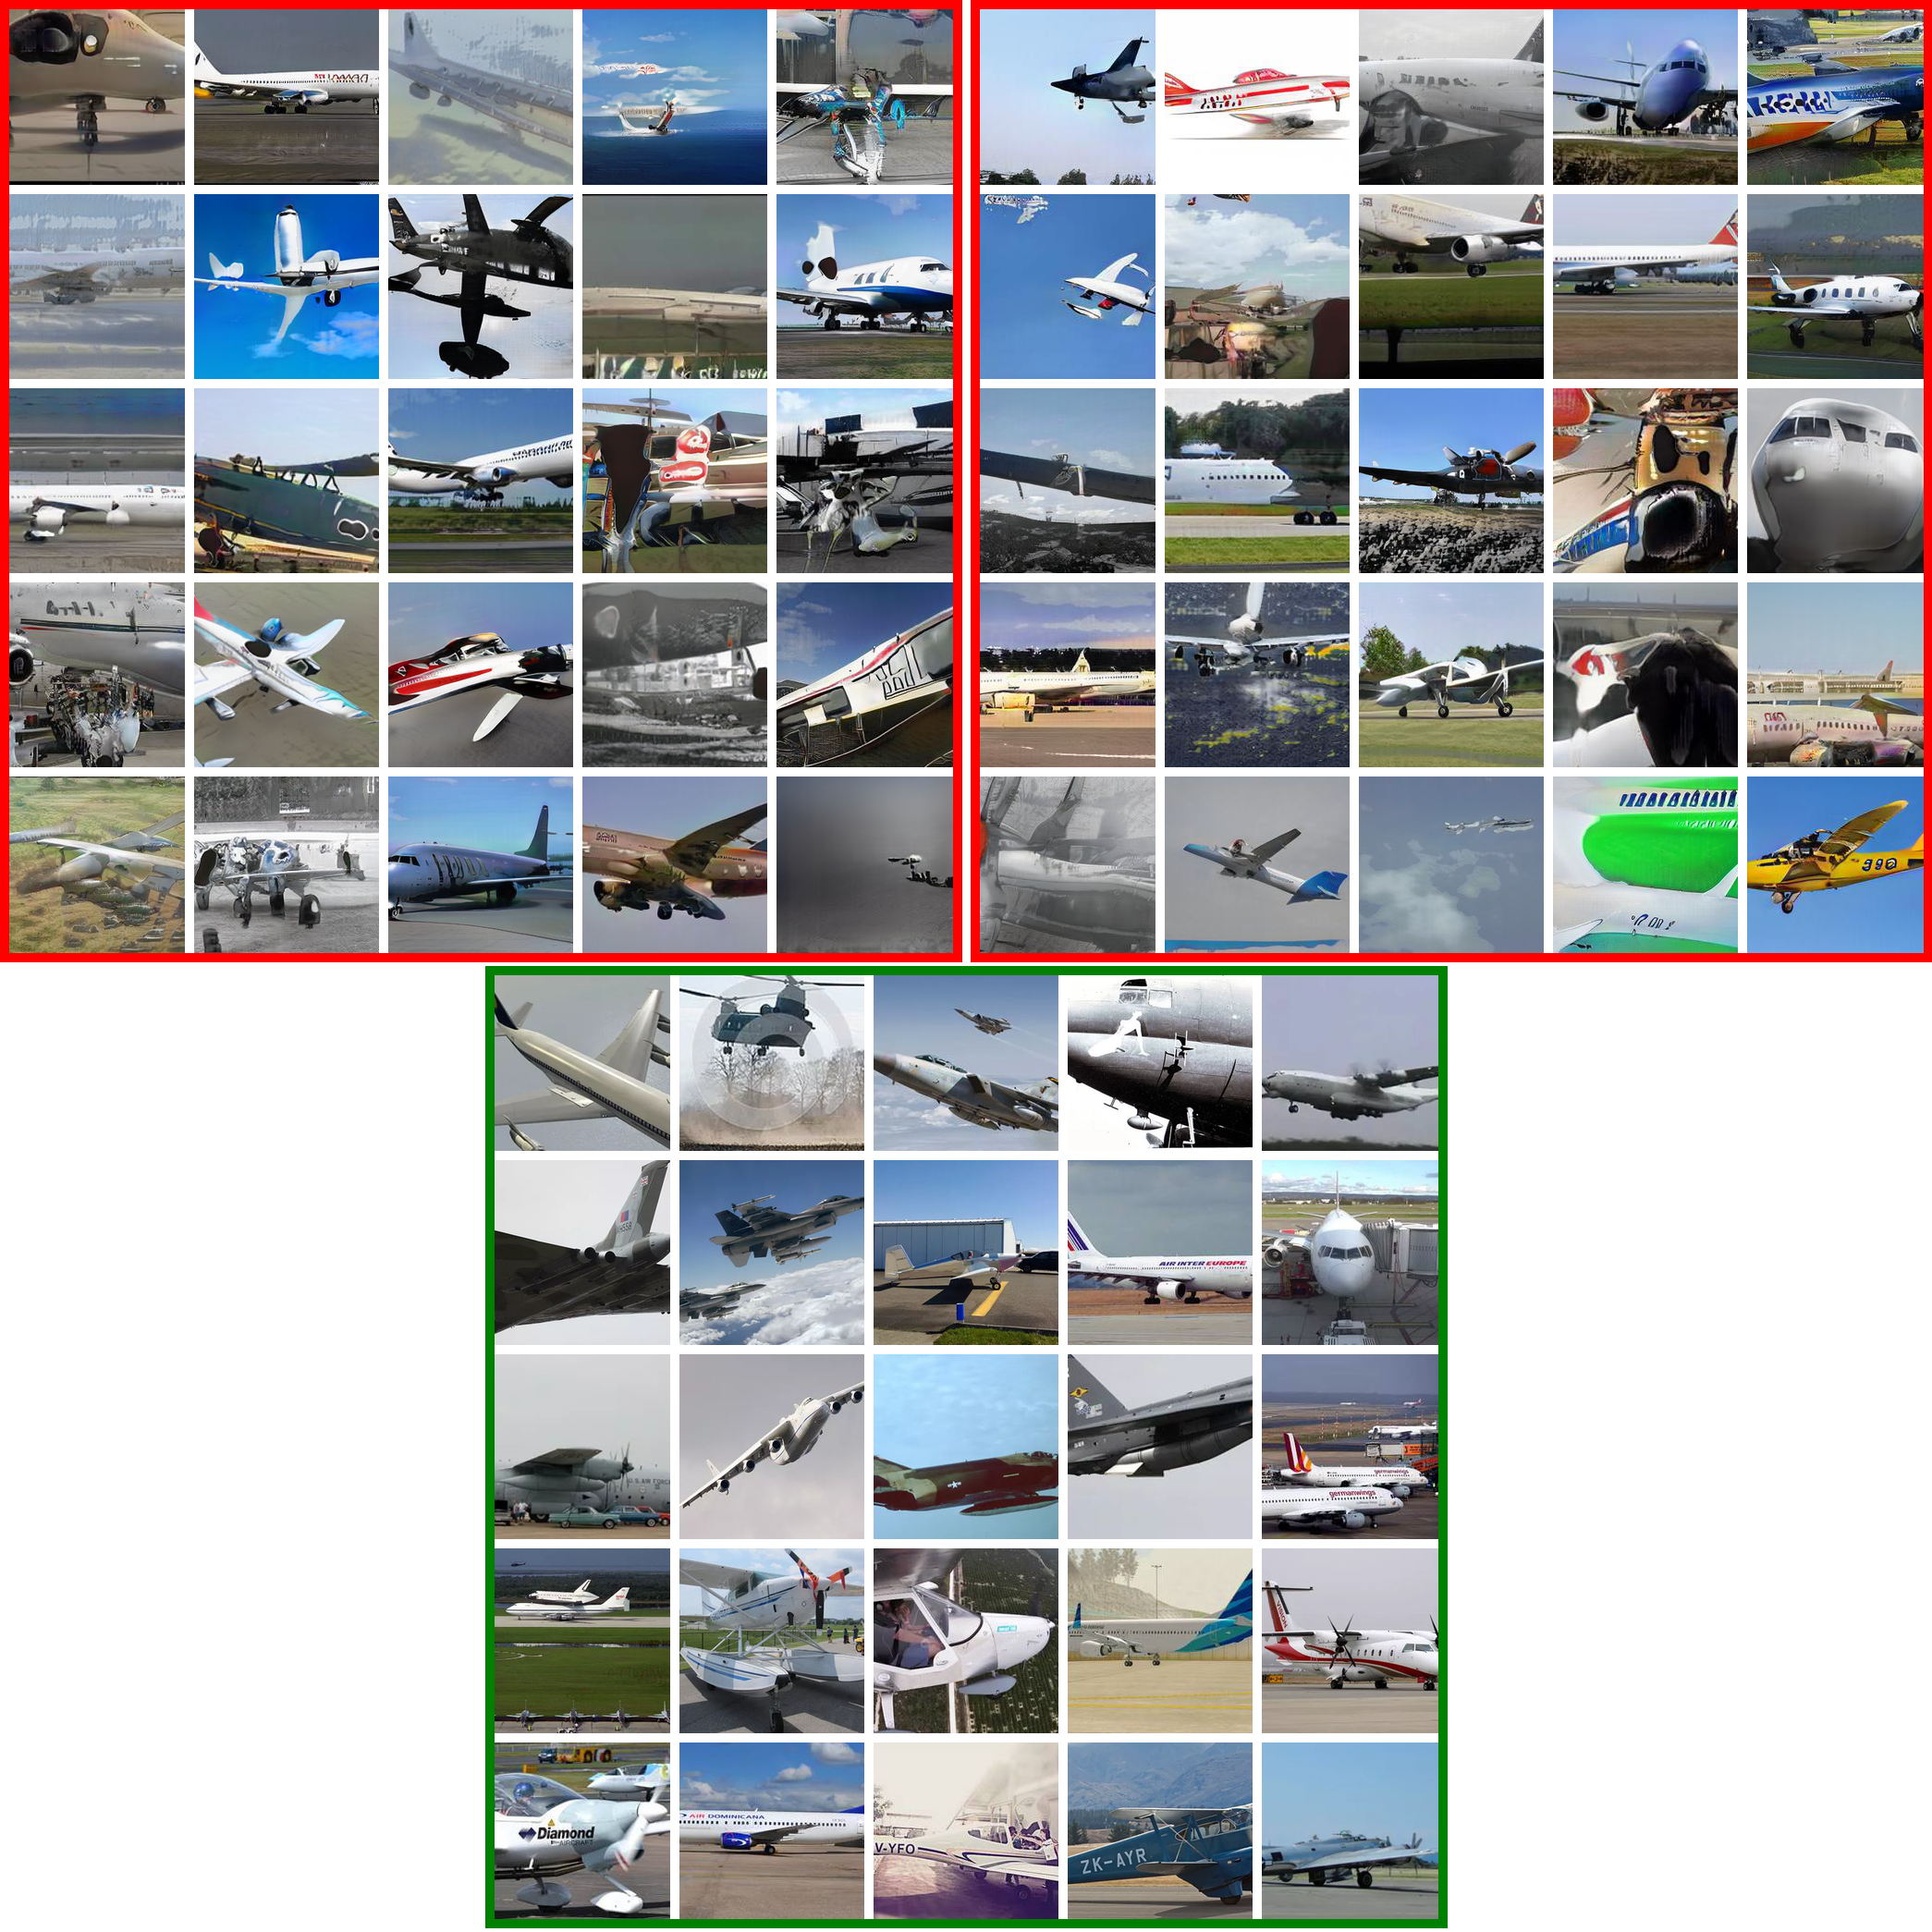

In [15]:
from IPython.display import display


# Create the final composite image
final_composite = create_final_composite(fakeA_images, fakeB_images, real_images)

# Save or display the final composite image

display(final_composite)

